# 單純只使用simsiam 
## embedding判斷人臉

### import package

In [3]:
import os
import numpy as np
import torch
import glob
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch import nn
from torchvision import datasets, transforms
from os import listdir
from os import walk
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import PIL.Image as Image
from matplotlib import pyplot as plt
import simsiam.loader
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm 
from IPython.display import clear_output
import math
import torch.nn.functional as F
from torch.nn import DataParallel
from sync_batchnorm import SynchronizedBatchNorm1d,  patch_replication_callback

### check gpu

In [54]:
DATA_PATH_TRAIN = '../../dataset/face_labeled_data/train'
DATA_PATH_VAL = '../../dataset/face_labeled_data/val'
DATA_PATH_TEST = '../../dataset/face_labeled_data/test'
# DATA_PATH_NEVER = '../../dataset/face_labeled_data/never_seen'
DATA_PATH_NEVER = '../../dataset/CASIA-WebFace'


# MODEL_PATH = "./model_facenet_simsiam/checkpoint_0100.pth.tar"
# MODEL_PATH = "./model_featureExtraction_triplet/checkpoint_0100.pth.tar"
MODEL_PATH = "./model_V2_1024_fix_only_cross/checkpoint.pth.tar"
BATCH_SIZE = 32
WORKERS = 8

print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

### Data augmentation

In [55]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          
def get_aug_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

def ge_eval_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

trans_aug = get_aug_trnsform(0.5)
trans_eval = get_aug_trnsform(0.5)

#### Define dataset, and dataloader

In [56]:
class FaceImages(Dataset):
    
    def __init__(self, img_dir, transform, specific = '**'):
        self.img_dir = img_dir
        self.img_path_list = glob.glob(os.path.join(img_dir, specific + '/*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, idx):
        img_path = self.img_path_list[idx]
        img = FaceImages.read_image(img_path)
        target = img_path.split('/')[5]
        return self.transform(img), self.transform(img), target
    
    @staticmethod
    def read_image(img_path):
        #return cv2.imread(img_path)
        return Image.open(img_path, mode='r').convert('RGB')

In [57]:
# dataset_train = FaceImages(DATA_PATH_TRAIN, transform=trans_aug)
# dataset_val = FaceImages(DATA_PATH_VAL, transform=trans_eval)
# dataset_test = FaceImages(DATA_PATH_TEST, transform=trans_eval)

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset_train = datasets.ImageFolder(DATA_PATH_TRAIN, transform=trans)
dataset_val = datasets.ImageFolder(DATA_PATH_VAL, transform=trans)
dataset_test = datasets.ImageFolder(DATA_PATH_TEST, transform=trans)
dataset_never = datasets.ImageFolder(DATA_PATH_NEVER, transform=trans)

train_loader = DataLoader(
    dataset_train,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    dataset_val,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loader = DataLoader(
    dataset_test,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

never_loader = DataLoader(
    dataset_never,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### load model

In [58]:
# make embedding to length=1
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [59]:
import torchvision.models as models

def loadEvalModel(model_path):
#     backbone = InceptionResnetV1()
#     projector = nn.Sequential(
#     nn.Linear(512, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
#     nn.Linear(2048, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
#     nn.Linear(2048, 512), L2_norm()
#     ) 
#     projector = nn.Sequential(
#         nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
#         nn.Linear(1024, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
#         nn.Linear(1024, 512), L2_norm()
#     ) 
#     model = nn.Sequential(
#     backbone,
#     projector
#     )
#     model = InceptionResnetV1()
#     model.load_state_dict(torch.load(model_path)['state_dict'])
#     model = torch.load(MODEL_PATH)
#     model = InceptionResnetV1(pretrained = 'casia-webface')
#     model = InceptionResnetV1(pretrained = 'vggface2')
    model = models.resnet50(pretrained=True).to(device)

    model.to(device)
    model.eval()
    return model

### collapse check(simularity matrix)

In [60]:
def collapseCheck(model, loader):
    x, _ = next(iter(loader))
    h = model(x.to(device))
    h_norm = h / h.norm(dim=1)[:, None]
    res = torch.mm(h_norm, h_norm.transpose(0,1))
    print(res.cpu().detach().numpy())

### validation

In [80]:
def validation(data_loader, model):
    y_pre_list = []
    y_list = []    
    for i_batch, image_batch in tqdm(enumerate(data_loader)):
        x = image_batch[0].to(device)
        y = image_batch[1]
        y_pre = model(x)
        y_pre = y_pre.cpu().detach().numpy()
        for j, data in enumerate(y_pre):
            y_pre_list.append(data)
            y_list.append(int(y[j]))
        if (len(y_list) > 3000):
            break
    return y_pre_list, y_list

In [81]:
size=dataset_never.__len__()
print('val data size = ', size)

val data size =  494424


### 計算兩embeddings之距離
distance_metric = 0 歐幾里得距離  (Euclidean distance)  
distance_metric = 1 餘弦相似性 (Cosine similarity)

In [82]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidean distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric 
    return dist

### 計算Cluste  離散度
1.根據target分群  
2.計算每一群中心點  
3.每一群的所有點對中心點計算歐式距離  
4.上步驟所有距離取平均  
5.所有群的平均距離再取平均  


In [83]:
def calculateClusterDistance(y_pre, target):
    dist = []
    y_new = np.array(y_pre)
    for index, target_str in enumerate(np.unique(target)):
        cluster_dist = 0
        data = y_new[[x for x, y in list(enumerate(target))if y == target_str]]
        meanPoint = np.mean(data, axis=0)
        for embedding in data:
            cluster_dist += distance(embedding, meanPoint)
        dist.append(cluster_dist / len(data))
    return np.mean(dist)

In [84]:
def calculateClusterVAL(y_pre, target, d = 1):
    ta = []
    y_new = np.array(y_pre)
    for index, target_str in tqdm(enumerate(np.unique(target))):
        data = y_new[[x for x, y in list(enumerate(target))if y == target_str]]
        count = 0
        ta_count = 0
        if len(data) <= 1:
            continue
        for i in range(len(data) - 1):
            for j in range(i + 1, len(data)):
                count+=1
                if distance(data[i], data[j]) <= d:
                    ta_count+=1
        ta.append(ta_count / count)
    return np.mean(ta)
def calculateClusterFAR(y_pre, target, d = 1):
    fa = []
    y_new = np.array(y_pre)
    for index, target_str in tqdm(enumerate(np.unique(target))):
        data = y_new[[x for x, y in list(enumerate(target))if y == target_str]]
        other_data = y_new[[x for x, y in list(enumerate(target))if y != target_str]]
        count = 0
        fa_count = 0
        if len(data) <= 1:
            continue
        for i in range(len(data)):
            for j in range(len(other_data)):
                count+=1
                if distance(data[i], other_data[j]) <= d:
                    fa_count+=1
        fa.append(fa_count / count)
    return np.mean(fa)

def calculateClusterVAL_FAR(y_pre, target, val_d, far_d):
    y_new = np.array(y_pre)
    ta_count = 0
    ta_count_true = 0
    fa_count = 0
    fa_count_true = 0
    for i in range(len(y_new) - 1):
        for j in range(i, len(y_new)):
            dist = distance(y_new[i], y_new[j])
            if target[i] == target[j]:
                ta_count += 1
                if dist <= val_d:
                    ta_count_true += 1
            else:
                fa_count += 1
                if dist <= far_d:
                    fa_count_true +=1
    return ta_count_true / ta_count, fa_count_true / fa_count

### Acc公式
對每一筆data找k個最近的data 看有多少是相同的class

### TA 公式
<img src="img/TA.png" width="50%">  

### FA 公式
<img src="img/FA.png" width="50%">  

### VAL FAR
<img src="img/VAL_FAR.png" width="50%"> 

### gpu 算距離

In [85]:
def pdist(v):
    dist = torch.norm(v[:, None] - v, dim=2, p=2)
    return dist

def pairwise_distance_torch(embeddings, device):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      embeddings: 2-D Tensor of size [number of data, feature dimension].
    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """

    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def makemask(targets):
    n = targets.shape[0]
    # find the hardest positive and negative
    mask_pos = targets.expand(n, n).eq(targets.expand(n, n).t())
    mask_neg = ~mask_pos
    mask_pos[torch.eye(n).byte().to(device)] = 0
    return mask_pos, mask_neg

def calculateClusterVAL_FAR_GPU(y_pre, target, val_d = 1., far_d = 1.):
#     dist = pdist(torch.Tensor(y_pre).cpu())
    dist = pairwise_distance_torch(torch.Tensor(y_pre).to(device), device).cpu()
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())
    
#     print(dist)
    dist[dist == 0] = float('nan')
    
    pos = dist * mask_pos.float()
#     print('pos pre', pos)
    pos[pos == 0] = float('nan')

    neg = dist * mask_neg.float()
#     print('neg pre', neg)
    neg[neg == 0] = float('nan')
#     print('mask_pos ', mask_pos)
#     print('mask_neg ', mask_neg)
#     print('pos ', pos)
#     print('neg ', neg)
    ta = torch.sum(pos <= far_d)
    fa = torch.sum(neg <= far_d)

    psame = torch.sum(mask_pos == True)
    pdiff = torch.sum(mask_neg == True)
    
    val = ta / psame
    far = fa / pdiff
    return val.detach().numpy(), far.detach().numpy()

def calculateClusterACC_GPU(y_pre, target, k = 5):
#     dist = pdist(torch.Tensor(y_pre).cpu())
    dist = pairwise_distance_torch(torch.Tensor(y_pre).to(device), device).cpu()
    dist[dist == 0] = float('nan')
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())
    values, indices = torch.topk(dist, k, largest = False)
    
    acc_count = torch.sum(torch.gather(mask_pos, 1, indices) == True, 1)
    acc = acc_count / k
    return acc.detach().numpy().mean()

def calculateClusterDistClose_GPU(y_pre, target):
#     dist = pdist(torch.Tensor(y_pre).cpu())
    dist = pairwise_distance_torch(torch.Tensor(y_pre).to(device), device).cpu()
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())    
#     print(dist)
    dist[dist == 0] = float('nan')
    pos = dist * mask_pos.float()
#     print('pos pre', pos)
    pos[pos == 0] = float('nan')
    neg = dist * mask_neg.float()
#     print('neg pre', neg)
    neg[neg == 0] = float('nan')
#     print('mask_pos ', mask_pos)
#     print('mask_neg ', mask_neg)
#     print('pos ', pos)
#     print('neg ', neg)
    sameD_val = torch.nansum(pos)
    diffD_val = torch.nansum(neg)

    psame = torch.sum(mask_pos == True)
    pdiff = torch.sum(mask_neg == True)
    
#     print('sameD_val ', sameD_val)
#     print('diffD_val ', diffD_val)
#     print('psame ', psame)
#     print('pdiff ', pdiff)
    sameD = sameD_val / psame
    diffD = diffD_val / pdiff
    return sameD.detach().numpy(), diffD.detach().numpy()

In [86]:
def cal(y_pre, y, kMax = 5):
    valList = []
    farList = []
    accList = []
    accK = []
#     ds = [2, 1.5, 1, 0.5, 10**-1, 10**-2, 10**-3, 10**-4, 10**-5, 10**-6]
    for i in tqdm(range(21)):
        power = i - 1
        val, far = calculateClusterVAL_FAR_GPU(y_pre, y, i / 10, i / 10)
        valList.append(val)
        farList.append(far)
    for k in tqdm(range(1, kMax + 1)):
        acc = calculateClusterACC_GPU(y_pre, y, k)
        accList.append(acc)
        accK.append(k)    
    return valList, farList, accList, accK
# valList, farList, accList, accK = cal(y_pre, y, 10)

In [87]:
def showVAL_FAR_ACC(valList, farList, accList, accK):
    fig, axs = plt.subplots(2, 1, figsize=(6, 10))
    plt.title('VAL_FAR')
    
    axs[1].set_ylim([0,1])
    
    axs[0].title.set_text('VAL_FAR')
    axs[1].title.set_text('acc(k)')

    axs[0].set_xlabel('FAR')
    axs[0].set_ylabel('VAL')

    axs[1].set_xlabel('k')
    axs[1].set_ylabel('acc')

    # plt.legend(['model'], loc='center right')
    axs[0].scatter(farList, valList)
    axs[0].plot(farList, valList)
    axs[1].scatter(accK, accList)
    axs[1].plot(accK, accList)
    
    for x,y in zip(accK,accList):
        label = "{:.2f}".format(y * 100)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    plt.savefig('ROC_ACC.png')
    plt.show()
# showVAL_FAR_ACC(valList, farList, accList, accK)

### PCA T-SNE

In [88]:
from sklearn.decomposition import PCA
def feature2pca(y_pre):
    pca = PCA(n_components=2)
    return pca.fit_transform(y_pre)

In [89]:
from sklearn import manifold
def featurn2tsne(y_pre):
    return manifold.TSNE(n_components=2, init='random', random_state=5, verbose=0).fit_transform(y_pre)

In [90]:
def draw_cluster(ax, pca_data, target, name):
    times = [0 for i in range(len(dataset_never.class_to_idx))]
#     plt.legend(dataset_never.class_to_idx.keys(), loc='center right')
    ax.set_title(name)
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    
    scatter = ax.scatter(pca_data[:,0], pca_data[:,1] , c=target, marker='o')#, cmap=cmap)
    ax.legend(*scatter.legend_elements(), loc=1)

In [91]:
def auto_dimension_reduction(y_pre, y):
    fig, axs = plt.subplots(2, 1, figsize=(6, 10))
    y_pre_pca = feature2pca(y_pre)
    y_pre_tsne = featurn2tsne(y_pre)
    draw_cluster(axs[0], y_pre_pca, y, 'PCA')
    draw_cluster(axs[1], y_pre_tsne, y, 'T-SNE')
    plt.savefig('PCA_TSNE.png')
    plt.show()

### 一鍵測試

In [ ]:
def auto_test(model_path):
    fast_model = loadEvalModel(model_path)
    collapseCheck(fast_model, never_loader)
    y_pre, y = validation(never_loader, fast_model)
    sameDist, diffDist = calculateClusterDistClose_GPU(y_pre, y)
    print('sameDist ', sameDist, ', diffDist ', diffDist, ', S/D ', sameDist / diffDist)
    valList, farList, accList, accK = cal(y_pre, y)
    showVAL_FAR_ACC(valList, farList, accList, accK)
    y_pre, y = validation(never_loader, fast_model)
    return y_pre, y

In [ ]:
np.unique(y_1)
for i in np.unique(y_1):
    print(i, ", ", y_1.count(i))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe6cbd717a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[[1.         0.8324982  0.7707865  ... 0.77589005 0.8113765  0.82588387]
 [0.8324982  0.99999994 0.68076    ... 0.65604883 0.7636625  0.7638565 ]
 [0.7707865  0.68076    1.         ... 0.6815294  0.6643747  0.6968179 ]
 ...
 [0.77589005 0.65604883 0.6815294  ... 1.         0.8618603  0.8562677 ]
 [0.8113765  0.7636625  0.6643747  ... 0.8618603  1.0000001  0.87021655]
 [0.82588387 0.7638565  0.6968179  ... 0.8562677  0.87021655 1.        ]]


0it [00:00, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe6cbd717a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe6cbd717a0>

AssertionError: Traceback (most recent call last):
can only test a child process  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive()

sameDist  0.49780655 , diffDist  0.5707791 , S/D  0.87215275


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


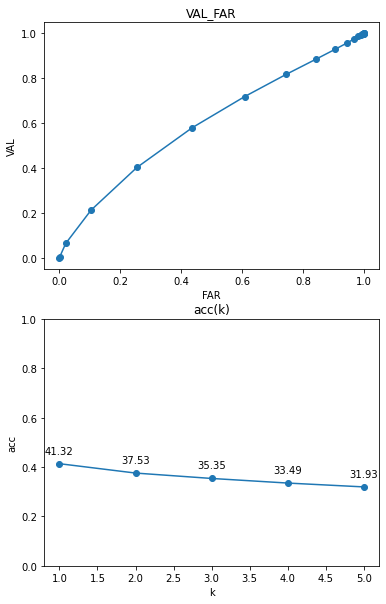

93it [00:05, 16.47it/s]


In [94]:
MODEL_PATH = "./model/model_simsiam_vicreg_cross/checkpoint.pth.tar"
y_pre_1, y_1 = auto_test(MODEL_PATH)
# auto_dimension_reduction(y_pre_1, y_1)

In [51]:
def calculateClusterACC_GPU_FIX(y_pre, target, k = 5):
    dist = pdist(torch.Tensor(y_pre).cpu())
#     dist = pairwise_distance_torch(torch.Tensor(y_pre).to(device), device).cpu()
#     print("dist A = ", dist)
    dist[dist == 0] = float('nan')
#     print("dist B = ", dist)
    mask_pos, mask_neg = makemask(torch.Tensor(target).cpu())
#     print("mask_pos = ", mask_pos)
#     print("mask_neg = ", mask_neg)

    values, indices = torch.topk(dist, k, largest = False)
#     print("values = ", values)
#     print("indices = ", indices)
    torch.gather(mask_pos, 1, indices)
    print("gather = ", torch.gather(mask_pos, 1, indices).int())
    aaa = torch.gather(mask_pos, 1, indices).float()
    acc_count = torch.sum(aaa, 1)
    acc = acc_count / k
    print("acc_count = ", acc_count)
    print("acc = ", acc)
    return acc.detach().numpy().mean()

100%|██████████| 9/9 [00:00<00:00, 242.05it/s]


gather =  tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)
acc_count =  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
acc =  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
gather =  tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]], dtype=torch.int32)
acc_count =  tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
acc =  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
gather =  tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        

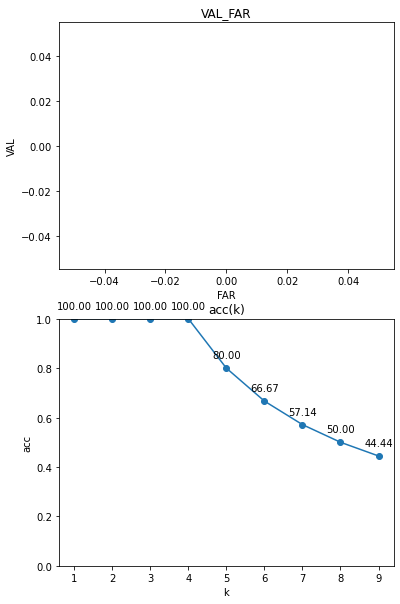

In [52]:
a= torch.normal(5, 3, size=(5, 512))
b = torch.normal(20, 3, size=(5, 512))
c = torch.normal(100, 3, size=(5, 512))
target = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
ab = torch.cat((a, b, c), 0)
acc = []
accList = []
accK = []
for k in tqdm(range(1, 9 + 1)):
    acc = calculateClusterACC_GPU_FIX(ab, target, k)
    accList.append(acc)
    accK.append(k) 
showVAL_FAR_ACC([], [], accList, accK)

In [47]:
a

tensor([[ 3.6815,  9.9609],
        [ 9.2554,  3.5687],
        [ 4.0408,  8.3986],
        [ 7.4135, 11.6167],
        [ 8.1564,  4.6473]])

In [48]:
b

tensor([[15.6679, 18.7912],
        [21.1439, 16.0063],
        [18.2702, 23.9762],
        [21.5455, 22.3243],
        [23.4730, 17.4070]])

In [49]:
ab

tensor([[ 3.6815,  9.9609],
        [ 9.2554,  3.5687],
        [ 4.0408,  8.3986],
        [ 7.4135, 11.6167],
        [ 8.1564,  4.6473],
        [15.6679, 18.7912],
        [21.1439, 16.0063],
        [18.2702, 23.9762],
        [21.5455, 22.3243],
        [23.4730, 17.4070]])